In [1]:
import sys
import traceback
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pn
import xarray as xr
import scipy.stats as stats

import pyOptimalEstimation as pyOE

%matplotlib inline
sns.set(style='ticks', palette='deep')

sys.path.append('lib')
import nonScatMWRadTran
import supporting_routines

/home/microway/anaconda3/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:29: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
/home/microway/anaconda3/lib/python3.9/abc.py:106: FutureWarning: xarray subclass customProfile should explicitly define __slots__
  cls = super().__new__(mcls, name, bases, namespace, **kwargs)


In [2]:
prior = xr.open_dataset('data/radiosonde_climatology_nsa_2002-2020.nc')

/home/microway/anaconda3/lib/python3.9/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [9]:
profileTT = np.array([
    '2004-03-16T12:00:00.000000000', '2006-04-01T00:00:00.000000000',
    '2009-01-30T18:00:00.000000000', '2014-07-27T06:00:00.000000000',
    '2018-01-08T12:00:00.000000000'
],dtype='datetime64[ns]')

profiles = prior.sel(time=profileTT)
prior = prior.drop_sel(time=profileTT)
nLev = len(prior.height)

In [3]:
priors = {'all': prior}

seasons = [
    'DJF',
    'MAM',
    'JJA',
    'SON',
]
months = (
    [12, 1, 2],
    [3, 4, 5],
    [6, 7, 8],
    [9, 10, 11],
)
for season, month in zip(seasons, months):
    priors[season] = prior.where(
        np.in1d(prior['time.month'], month)[:, np.newaxis]).dropna(
            'time', how='all')

In [4]:
prior_qts = {}
for season in priors.keys():
    prior_q = priors[season]['q'].to_pandas()
    prior_q.columns = ['%05i_q' % (i) for i in prior_q.columns]
    prior_t = priors[season]['temp'].to_pandas()
    prior_t.columns = ['%05i_t' % (i) for i in prior_t.columns]
    prior_qts[season] = pn.concat((prior_q, prior_t), axis=1)
    prior_qts[season] = prior_qts[season].reindex(
        sorted(prior_qts[season].columns), axis=1)


In [5]:
x_cov = []
x_mean = []

for season in ['all'] + seasons:

    x_cov1 = prior_qts[season].cov().rename_axis('state', axis=0).rename_axis('stateT', axis=1)
    x_mean1 = prior_qts[season].mean().rename_axis('state', axis=0)

    x_cov.append(xr.DataArray(x_cov1))
    x_mean.append(xr.DataArray(x_mean1))

x_cov = xr.concat(x_cov, dim='season')
x_mean = xr.concat(x_mean, dim='season')

x_cov['season'] = ['all'] + seasons
x_mean['season'] = ['all'] + seasons

In [7]:
height = priors['all'].height

pressure = []
for k in ['all'] + seasons:
    pressure.append(priors[k].bar_pres.mean('time'))
pressure = xr.concat(pressure, dim='season')
pressure['season'] = ['all'] + seasons
pressure = pressure.to_pandas()
# pressure

In [11]:
profiles_t = profiles['temp'].to_pandas()
profiles_t.columns = ['%05i_t' % (i) for i in profiles_t.columns]
profiles_q = profiles['q'].to_pandas()
profiles_q.columns = ['%05i_q' % (i) for i in profiles_q.columns]

x_truths = pn.concat((profiles_t, profiles_q), 1)
x_truths = x_truths.reindex(sorted(x_truths.index), axis=0)
x_truths.columns.name = 'state'
x_truths.index.name = 'time'

assert np.all(np.isfinite(x_truths))
# x_truths

/tmp/ipykernel_137338/1542091133.py:6: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x_truths = pn.concat((profiles_t, profiles_q), 1)


In [13]:
def forwardRT(X, pressure=None, zenithAngle=0, frequencies=[]):

    # X contains T and Q, lets split the vector
    temperature, humidity = supporting_routines.splitTQ(X)
    # humdity is in log10 scale, convert to linear in kg/kg
    humidity = (10**humidity) / 1000.
    # Height in meters comes from index of the temperature (or humidty) vector
    heights = temperature.index
    assert np.all(np.diff(heights) > 0)

    # get absolute humidty from specific humdity
    abs_humidity = supporting_routines.q2a(humidity, pressure, temperature)
    
    # run the forward operator
    TB, tau, tau_wv, tau_o2 = nonScatMWRadTran.STP_IM10(
        heights,  # [m]  
        temperature,  # [K]
        pressure,  # [Pa]
        abs_humidity,  # [kgm^-3]
        zenithAngle,  # zenith angle of observation in deg.
        frequencies,  # frequency vector in GHz
    )
    return TB


In [14]:
frequencies = [
    22.24, 23.04, 23.84, 25.44, 26.24, 27.84, 31.4, 51.26, 52.28, 53.86, 54.94,
    56.66, 57.3, 58.
]
y_vars = np.array(frequencies)
x_vars = x_mean.state.values

In [19]:
season = 'MAM'  #Spring: March April May
profile = np.datetime64('2006-04-01T00:00:00')
x_truth = x_truths.loc[profile]

In [16]:
y_noise = pn.Series(
    [
        0.12026637, 0.10864162, 0.10412012, 0.0918477, 0.10174478, 0.10085633,
        0.10500476, 0.42303663, 0.45658514, 0.26291823, 0.25538793, 0.1773584,
        0.17556195, 0.59489495
    ],
    index=y_vars
)

S_y = pn.DataFrame(
    np.diag(y_noise.values**2),
    index=y_vars,
    columns=y_vars,
)


In [17]:
x_a = x_mean.sel(season='MAM').to_pandas()[x_vars]
S_a = x_cov.sel(season='MAM').to_pandas().loc[x_vars, x_vars]

In [20]:
forwardKwArgs = dict(
    pressure=pressure.loc['MAM'].values,
    zenithAngle=0,
    frequencies=frequencies
)

y_obs = forwardRT(x_truth, **forwardKwArgs)
y_obs = pn.Series(y_obs, index=y_vars)
assert np.all(np.isfinite(y_obs))

In [21]:
oe_ref = pyOE.optimalEstimation(
    x_vars, # state variable names
    x_a,  # a priori
    S_a, # a priori uncertainty
    y_vars,  # measurement variable names
    y_obs, # observations
    S_y, # observation uncertainty
    forwardRT, # forward Operator
    forwardKwArgs=forwardKwArgs, # additonal function arguments
    x_truth=x_truth, # true profile
)

In [22]:
oe_ref.doRetrieval()

0.70 s, iteration 1, degrees of freedom: 6.61 of 120, not converged (x-space):  787781.130
1.04 s, iteration 2, degrees of freedom: 6.28 of 120, not converged (x-space):  309558.850
1.38 s, iteration 3, degrees of freedom: 6.43 of 120, not converged (x-space):  60835.964
1.72 s, iteration 4, degrees of freedom: 6.51 of 120, not converged (x-space):  8269.530
2.06 s, iteration 5, degrees of freedom: 6.60 of 120, not converged (x-space):  2319.170
2.39 s, iteration 6, degrees of freedom: 6.67 of 120, not converged (x-space):  983.101
2.73 s, iteration 7, degrees of freedom: 6.64 of 120, not converged (x-space):  732.088
3.07 s, iteration 8, degrees of freedom: 6.46 of 120, not converged (x-space):  856.997
3.40 s, iteration 9, degrees of freedom: 6.38 of 120, not converged (x-space):  242.217


False

AttributeError: 'float' object has no attribute 'index'

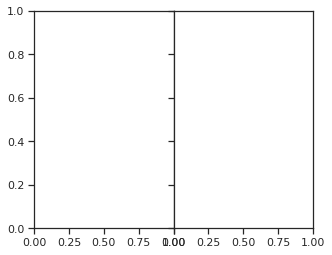

In [23]:
fig = supporting_routines.plotMwrResults(
    oe_ref,
    h=pressure.loc[season] / 100,
    hlabel='Pressure [hPa]',
    title='Reference run')

In [24]:
T_optimal, Q_optimal = supporting_routines.splitTQ(oe_ref.x_op)
T_truth, Q_truth = supporting_routines.splitTQ(oe_ref.x_truth)

print('RMS X Temperature: %g [K]'% np.sqrt(np.mean((T_optimal - T_truth)**2)))
print('RMS X Humidity: %g [log$_{10}$(g/kg)]'% np.sqrt(np.mean((10**Q_optimal - 10**Q_truth)**2)))
print('RMS Y %g [K]'% np.sqrt(np.mean((oe_ref.y_obs - oe_ref.y_op)**2)))

AttributeError: 'float' object has no attribute 'index'